In [1]:
import math
import os


os.environ["KERAS_BACKEND"] = "torch"


import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout, Normalization, Input
from keras.models import Sequential
from matplotlib import pyplot as plt


def is_prime(n):
    if n == 1:
        return False
    if n == 2:
        return True
    for ith in range(3, math.ceil(math.sqrt(n)), 2):
        if n % ith == 0:
            return False
            
    return True

In [24]:
df = pd.read_csv("../../.data/lowhigh_2023_2025.csv")
del df["Unnamed: 0"]
df = df[df["low"] != "NOT AVAILABLE"]
df = df.dropna()

In [46]:
import re


def treat_doubles(s):
    reg = re.compile(r"(\d+\.*\d*) (\d+\.*\d*)")
    if match := reg.search(s):
        return match.group(1)
    return s


murphy = df[df["market"] == "Murphy Public Market"]
murphy[murphy["commodity"] == "galunggong"]["low"].apply(treat_doubles).values
df[df["low"] == "45.00 NOT AVAILABLE"]

,date,market,commodity,low,high
136817,2025-01-14,Pritil Market/Manila,well-milled rice (local),45.00 NOT AVAILABLE,45.00 NOT AVAILABLE


In [3]:
data_by_commodities = {}

for commodity in set(df["commodity"]):
    # print("[INFO] processing:", commodity)
    data_by_commodities[commodity] = df.loc[df["commodity"] == commodity]

data_by_commodities

{'frozen pork liempo':               date                            market           commodity  \
 26810   2024-04-16                    Trabajo Market  frozen pork liempo   
 26823   2024-04-16            Taguig People's Market  frozen pork liempo   
 26888   2024-04-16           Mega Q-mart/Quezon City  frozen pork liempo   
 26902   2024-04-16    Maypajo Public Market/Caloocan  frozen pork liempo   
 26912   2024-04-16                    Bicutan Market  frozen pork liempo   
 ...            ...                               ...                 ...   
 146120  2025-02-06                   Cartimar Market  frozen pork liempo   
 146133  2025-02-06                    Bicutan Market  frozen pork liempo   
 146145  2025-02-06      Agora Public Market/San Juan  frozen pork liempo   
 146152  2025-02-06                    Dagonoy Market  frozen pork liempo   
 146164  2025-02-06  New Las Piñas City Public Market  frozen pork liempo   
 
            low    high  
 26810   270.00  270.00  


In [4]:
data_by_market = {}
for market in set(df["market"]):
    data_by_market[market] = df[df["market"] == market]

data_by_market

{'Muñoz Market/Quezon City':               date                    market          commodity    low   high
 182     2024-01-02  Muñoz Market/Quezon City           ampalaya   90.0  100.0
 194     2024-01-02  Muñoz Market/Quezon City     sugar (washed)   78.0   85.0
 195     2024-01-02  Muñoz Market/Quezon City  red onion (local)  160.0  200.0
 196     2024-01-02  Muñoz Market/Quezon City      pechay baguio   50.0   70.0
 197     2024-01-02  Muñoz Market/Quezon City            cabbage  60.00  80.00
 ...            ...                       ...                ...    ...    ...
 151784  2025-02-25  Muñoz Market/Quezon City  red onion (local)  150.0  170.0
 151785  2025-02-25  Muñoz Market/Quezon City             tomato   30.0   40.0
 151787  2025-02-25  Muñoz Market/Quezon City           ampalaya  100.0  120.0
 151810  2025-02-25  Muñoz Market/Quezon City           eggplant   60.0   80.0
 151831  2025-02-25  Muñoz Market/Quezon City            cabbage   50.0  120.0
 
 [4033 rows x 5 column

In [5]:
# df_commodity = data_by_commodities["cabbage (scorpio)"]
# df_commodity = data_by_commodities["eggplant"]  # NOTE: data too low, do not include
# df_commodity = data_by_commodities[""]
# df_commodity_market = df_commodity[df_commodity["market"] == "Pateros Market"]

df_market = data_by_market["Pateros Market"]
df_commodity_market = df_market[df_market["commodity"] == "egg (medium)"]
x = pd.to_datetime(df_commodity_market["date"])
low = pd.to_numeric(df_commodity_market["low"])
high = pd.to_numeric(df_commodity_market["high"])
df_commodity_market

,date,market,commodity,low,high
270,2024-01-02,Pateros Market,egg (medium),7.5,7.5
403,2024-01-03,Pateros Market,egg (medium),7.5,7.5
620,2024-01-04,Pateros Market,egg (medium),7.5,8.0
940,2024-01-05,Pateros Market,egg (medium),7.5,8.0
1344,2024-01-09,Pateros Market,egg (medium),7.5,8.0
...,...,...,...,...,...
149852,2025-02-19,Pateros Market,egg (medium),7.0,7.5
150128,2025-02-20,Pateros Market,egg (medium),7.0,7.5
150384,2025-02-21,Pateros Market,egg (medium),7.0,7.5
151217,2025-02-24,Pateros Market,egg (medium),7.0,7.5


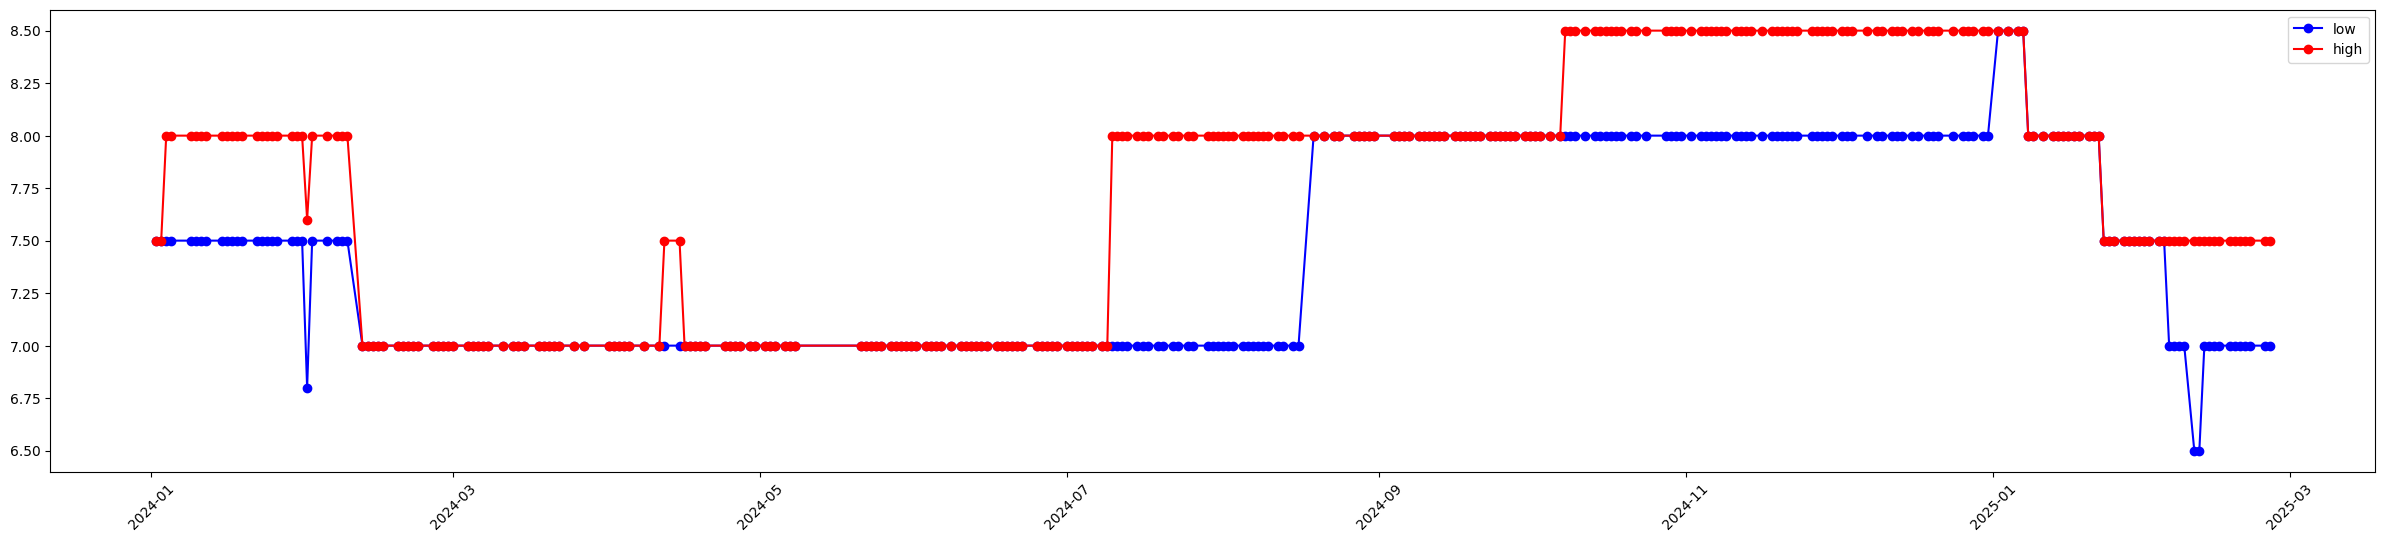

In [6]:
plt.figure(figsize=(30, 6))
plt.xticks(rotation=45)
plt.plot(x, low, "o-b", x, high, "o-r")
plt.legend(["low", "high"])

In [16]:
df_train = df_commodity_market[["high", "low"]]
if is_prime(df_train.shape[0]):
    df_train = df_train.iloc[1:]
df_train = df_train.iloc[::-1]
df_train.shape

np.var(df_train[["low", "high"]].to_numpy(dtype="float32"))

np.float32(0.3020077)

In [17]:
train_x = []
train_y = []
train_n_future = 1
train_n_past = 5

for ith in range(0, df_train.shape[0], train_n_past + train_n_future):
    tail = ith + train_n_past
    past = df_train.iloc[ith:tail].to_numpy(dtype="float32")
    if past.shape[0] == train_n_past:
        train_x.append(past)
    else:
        continue
    train_y.append(df_train.iloc[tail:tail + train_n_future, 0:1].to_numpy(dtype="float32"))

train_x, train_y

([array([[7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ]], dtype=float32),
  array([[7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ]], dtype=float32),
  array([[7.5, 6.5],
         [7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ],
         [7.5, 7. ]], dtype=float32),
  array([[7.5, 7.5],
         [7.5, 7.5],
         [7.5, 7.5],
         [7.5, 7.5],
         [7.5, 7.5]], dtype=float32),
  array([[7.5, 7.5],
         [7.5, 7.5],
         [7.5, 7.5],
         [7.5, 7.5],
         [8. , 8. ]], dtype=float32),
  array([[8., 8.],
         [8., 8.],
         [8., 8.],
         [8., 8.],
         [8., 8.]], dtype=float32),
  array([[8. , 8. ],
         [8. , 8. ],
         [8. , 8. ],
         [8. , 8. ],
         [8.5, 8.5]], dtype=float32),
  array([[8.5, 8.5],
         [8.5, 8.5],
         [8.5, 8. ],
         [8.5, 8. ],
         [8.5, 8. ]], dtype=float32),
  array([[8.5, 8. ],
         [8.5

In [9]:
train_x = np.array(train_x)
train_y = np.array(train_y)
train_x.shape, train_y.shape

((49, 5, 2), (49, 1, 1))

In [10]:
mean = np.mean([low, high])
var = np.var([low, high])

model = Sequential()
model.add(Input(shape=(train_x.shape[1], train_x.shape[2])))
model.add(Normalization(mean=mean, variance=var))
model.add(LSTM(128, activation="relu", return_sequences=True))
model.add(LSTM(64, activation="relu", return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(train_y.shape[1]))
model.add(Normalization(mean=mean, variance=var, invert=True))

model.compile(optimizer="nadam", loss="mse")
model.summary()

mean, var

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 128)         │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,545 (455.25 KB)

 Trainable params: 116,545 (455.25 KB)

 Non-trainable params: 0 (0.00 B)

(np.float64(7.5879661016949145), np.float64(0.30200772766446426))

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3774 - val_loss: 0.1316
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3220 - val_loss: 0.1279
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2808 - val_loss: 0.1240
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2661 - val_loss: 0.1183
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2046 - val_loss: 0.1147
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1359 - val_loss: 0.1179
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0661 - val_loss: 0.1411
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0494 - val_loss: 0.1810
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0353 - val_loss: 0.2052
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0270 - val_loss: 0.1990
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0214 - val_loss: 0.1732
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0263 - val_lo

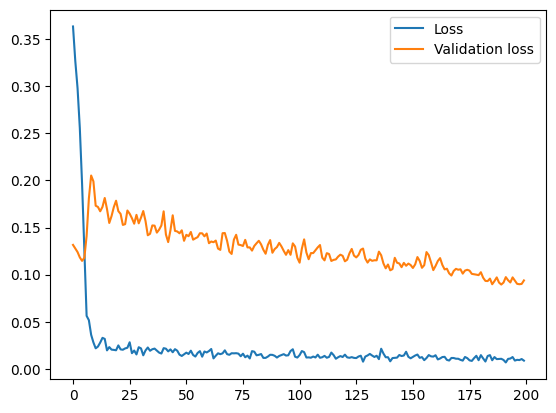

In [11]:
hist = model.fit(train_x, train_y, epochs=200, batch_size=16, validation_split=0.1, verbose=1)
plt.plot(hist.history["loss"], label="Loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


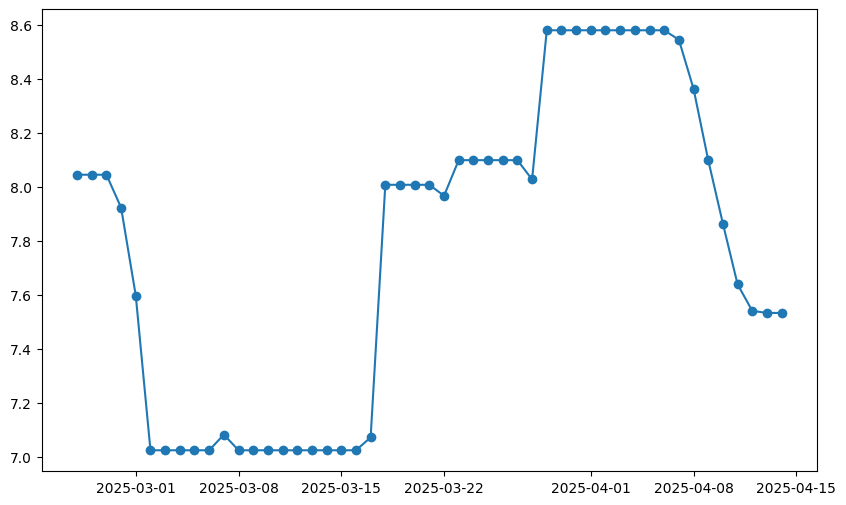

In [12]:
days_to_predict = train_x.shape[0]
train_x_rev = train_x[::-1] 
date = pd.to_datetime(df.iloc[df.shape[0] - 1]["date"])
dates = [date + pd.Timedelta(days=ith) for ith in range(days_to_predict)]
prices = model.predict(train_x_rev[-days_to_predict:])
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, "o-")

In [13]:
prices

array([[8.044268 ],
       [8.044268 ],
       [8.044268 ],
       [7.9222317],
       [7.595952 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.0812182],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.023158 ],
       [7.0708094],
       [8.006936 ],
       [8.006936 ],
       [8.006936 ],
       [8.006936 ],
       [7.966189 ],
       [8.098238 ],
       [8.098238 ],
       [8.098238 ],
       [8.098238 ],
       [8.098238 ],
       [8.026746 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.579545 ],
       [8.544583 ],
       [8.362527 ],
       [8.098238 ],
       [7.8629527],
       [7.638009 ],
       [7.5398316],
       [7.532132 ],
       [7.532132 ]], dtype=float32)